In [2]:
import pandas as pd
import numpy as np
import numbers
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, SimpleRNN
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
)
import matplotlib.pyplot as plt
import seaborn as sns


def convert_to_numerical(value):
    if isinstance(value, numbers.Number):
        return value
    if pd.isna(value):
        return np.nan
    value = value.replace(",", "")
    if "B" in value:
        return float(value.replace("B", "")) * 1e9
    elif "M" in value:
        return float(value.replace("M", "")) * 1e6
    elif "K" in value:
        return float(value.replace("K", "")) * 1e3
    return float(value)


# Load the dataset
df = pd.read_csv("egx30.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date", ascending=True)


# Delete change column to not affect our result
del df["Change %"]
df = df.rename(columns={"Price": "Close"})


# Convert columns to numeric
cols = ["Open", "High", "Low", "Close", "Vol."]

for col in cols:
    df[col] = df[col].apply(convert_to_numerical)


# Handle missing data by averaging the previous and next rows
def fill_with_window_average(df,cols):
    for column in cols:
        df[column] = df[column].apply(lambda x: x if not pd.isna(x) else custom_fill(df, column, df[column].index[df[column].isna() == True]))

def custom_fill(df, column, idx):
    for i in idx:
        # Define the window range, ensuring it does not go out of DataFrame's bounds
        start_idx = max(i - 3, 0)
        end_idx = min(i + 4, len(df))  # +4 because upper bound in Python slicing is exclusive
        # Calculate the mean of the window, excluding NaNs
        window_values = df[column][start_idx:end_idx].dropna()
        # Fill the NaN with the computed mean if possible
        if len(window_values) > 0:
            df.at[i, column] = window_values.mean()
        else:
            # If no valid values exist in the window, leave as NaN or handle differently
            df.at[i, column] = np.nan

fill_with_window_average(df,cols)

# Normalize the features
scaleddata=df.copy()
scalers = {}
for col in cols:
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaleddata[col] = scaler.fit_transform(df[[col]])
    scalers[col] = scaler
    
scaleddata.set_index("Date", inplace=True)
scaleddata

2024-05-22 17:29:21.663656: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


,Close,Open,High,Low,Vol.
Date,,,,,
2010-01-03,0.090128,0.088028,0.085869,0.089641,0.019648
2010-01-04,0.091870,0.090060,0.087798,0.091831,0.037567
2010-01-05,0.095112,0.092598,0.090945,0.094439,0.029552
2010-01-06,0.095661,0.094636,0.091640,0.096419,0.047121
2010-01-10,0.096981,0.096525,0.093547,0.098470,0.037156
...,...,...,...,...,...
2024-05-15,0.729278,0.731808,0.707652,0.736229,0.146625
2024-05-16,0.757025,0.729328,0.730107,0.740952,0.153046
2024-05-19,0.796393,0.761551,0.767839,0.773668,0.148367


In [3]:
# Convert series to supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [("%s(t-%d)" % (df.columns[j], i)) for j in range(n_vars)]
    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [("%s(t)" % (df.columns[j])) for j in range(n_vars)]
        else:
            names += [("%s(t+%d)" % (df.columns[j], i)) for j in range(n_vars)]
    # Concatenate all columns
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg


# Frame as supervised learning
n_days = 1
reframed = series_to_supervised(scaleddata,n_days, 1)
reframed


,Close(t-1),Open(t-1),High(t-1),Low(t-1),Vol.(t-1),Close(t),Open(t),High(t),Low(t),Vol.(t)
Date,,,,,,,,,,
2010-01-04,0.090128,0.088028,0.085869,0.089641,0.019648,0.091870,0.090060,0.087798,0.091831,0.037567
2010-01-05,0.091870,0.090060,0.087798,0.091831,0.037567,0.095112,0.092598,0.090945,0.094439,0.029552
2010-01-06,0.095112,0.092598,0.090945,0.094439,0.029552,0.095661,0.094636,0.091640,0.096419,0.047121
2010-01-10,0.095661,0.094636,0.091640,0.096419,0.047121,0.096981,0.096525,0.093547,0.098470,0.037156
2010-01-11,0.096981,0.096525,0.093547,0.098470,0.037156,0.096417,0.096088,0.092000,0.097418,0.056001
...,...,...,...,...,...,...,...,...,...,...
2024-05-15,0.730073,0.731555,0.713539,0.737451,0.105532,0.729278,0.731808,0.707652,0.736229,0.146625
2024-05-16,0.729278,0.731808,0.707652,0.736229,0.146625,0.757025,0.729328,0.730107,0.740952,0.153046
2024-05-19,0.757025,0.729328,0.730107,0.740952,0.153046,0.796393,0.761551,0.767839,0.773668,0.148367


In [4]:
# Split into train and test sets
values = reframed
n_test_days = int(len(values) * 0.7)
trainDf = reframed
testDf = reframed[n_test_days:]

train=trainDf.values
test=testDf.values

# Split into input and outputs
n_obs = train.shape[1] // 2
train_X, train_y = train[:, :n_obs], train[:, -n_obs]
test_X, test_y = test[:, :n_obs], test[:, -n_obs]

# Reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_days, train_X.shape[1] // n_days))
test_X = test_X.reshape((test_X.shape[0], n_days, test_X.shape[1] // n_days))
testDf

,Close(t-1),Open(t-1),High(t-1),Low(t-1),Vol.(t-1),Close(t),Open(t),High(t),Low(t),Vol.(t)
Date,,,,,,,,,,
2020-02-06,0.349061,0.346524,0.336124,0.352293,0.054725,0.353045,0.348945,0.340032,0.354751,0.063452
2020-02-09,0.353045,0.348945,0.340032,0.354751,0.063452,0.353125,0.352929,0.340540,0.358791,0.039695
2020-02-10,0.353125,0.352929,0.340540,0.358791,0.039695,0.348799,0.353009,0.339601,0.353977,0.039413
2020-02-11,0.348799,0.353009,0.339601,0.353977,0.039413,0.349805,0.348683,0.337810,0.354485,0.031435
2020-02-12,0.349805,0.348683,0.337810,0.354485,0.031435,0.344295,0.349689,0.336400,0.349768,0.032600
...,...,...,...,...,...,...,...,...,...,...
2024-05-15,0.730073,0.731555,0.713539,0.737451,0.105532,0.729278,0.731808,0.707652,0.736229,0.146625
2024-05-16,0.729278,0.731808,0.707652,0.736229,0.146625,0.757025,0.729328,0.730107,0.740952,0.153046
2024-05-19,0.757025,0.729328,0.730107,0.740952,0.153046,0.796393,0.761551,0.767839,0.773668,0.148367


In [5]:

# Define the LSTM model
lstm = Sequential()
lstm.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
lstm.add(Dense(1))
lstm.compile(loss="mae", optimizer="adam")

# Fit network
lstmhistory = lstm.fit(
    train_X,
    train_y,
    epochs=50,
    batch_size=72,
    validation_data=(test_X, test_y),
    verbose=2,
    shuffle=False,
)


# Define the RNN model
rnn = Sequential()
rnn.add(SimpleRNN(50, input_shape=(train_X.shape[1], train_X.shape[2])))
rnn.add(Dense(1))
rnn.compile(loss="mae", optimizer="adam")

# Fit network
rnnhistory = rnn.fit(
    train_X,
    train_y,
    epochs=50,
    batch_size=72,
    validation_data=(test_X, test_y),
    verbose=2,
    shuffle=False,
)

Epoch 1/50


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48/48 - 2s - 38ms/step - loss: 0.0770 - val_loss: 0.0631
Epoch 2/50
48/48 - 0s - 4ms/step - loss: 0.0745 - val_loss: 0.0383
Epoch 3/50
48/48 - 0s - 4ms/step - loss: 0.0370 - val_loss: 0.0183
Epoch 4/50
48/48 - 0s - 4ms/step - loss: 0.0211 - val_loss: 0.0178
Epoch 5/50
48/48 - 0s - 4ms/step - loss: 0.0126 - val_loss: 0.0105
Epoch 6/50
48/48 - 0s - 3ms/step - loss: 0.0118 - val_loss: 0.0144
Epoch 7/50
48/48 - 0s - 2ms/step - loss: 0.0108 - val_loss: 0.0095
Epoch 8/50
48/48 - 0s - 2ms/step - loss: 0.0115 - val_loss: 0.0140
Epoch 9/50
48/48 - 0s - 2ms/step - loss: 0.0105 - val_loss: 0.0093
Epoch 10/50
48/48 - 0s - 2ms/step - loss: 0.0112 - val_loss: 0.0148
Epoch 11/50
48/48 - 0s - 2ms/step - loss: 0.0101 - val_loss: 0.0094
Epoch 12/50
48/48 - 0s - 2ms/step - loss: 0.0112 - val_loss: 0.0152
Epoch 13/50
48/48 - 0s - 2ms/step - loss: 0.0102 - val_loss: 0.0096
Epoch 14/50
48/48 - 0s - 2ms/step - loss: 0.0113 - val_loss: 0.0144
Epoch 15/50
48/48 - 0s - 2ms/step - loss: 0.0097 - val_loss: 0.0099

In [189]:

def evalute_model(model: Sequential, name, dataframe: pd.DataFrame):

    # Make predictions on the test set
    predictions = model.predict(test_X)
    predictions = model.predict(test_X)

    # Calculate MAE
    mae = mean_absolute_error(test_y, predictions)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test_y, predictions))

    # Calculate MSE
    mse = mean_squared_error(test_y, predictions)

    # Evaluate your model
    # loss = model.evaluate(test_X, test_y)
    return (
        pd.concat(
            [
                dataframe,
                pd.DataFrame(
                    {
                        "MAE": [mae],
                        "MSE": [mse],
                        "RMSE": [rmse],
                        # "Loss": [accuracy],
                    },index=[name]
                ),
            ]
        ),
        predictions,mae,rmse,mse,
    )

metrics_df = pd.DataFrame(columns=["MAE","MSE" ,"RMSE",])
metrics_df,lstm_prediction ,mae_lstm,rmse_lstm,mse_lstm= evalute_model(lstm,  "LSTM", metrics_df)
metrics_df,rnn_prediction,mae_rnn,rmse_rnn,mse_rnn = evalute_model(rnn,  "RNN", metrics_df)

print(metrics_df.head())

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step


/var/folders/dg/1_rgz4vj65nglywrnw1626nh0000gn/T/ipykernel_86549/2797157346.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pd.concat(


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step
           MAE       MSE      RMSE
LSTM  0.010069  0.000176  0.013262
RNN   0.008711  0.000147  0.012118


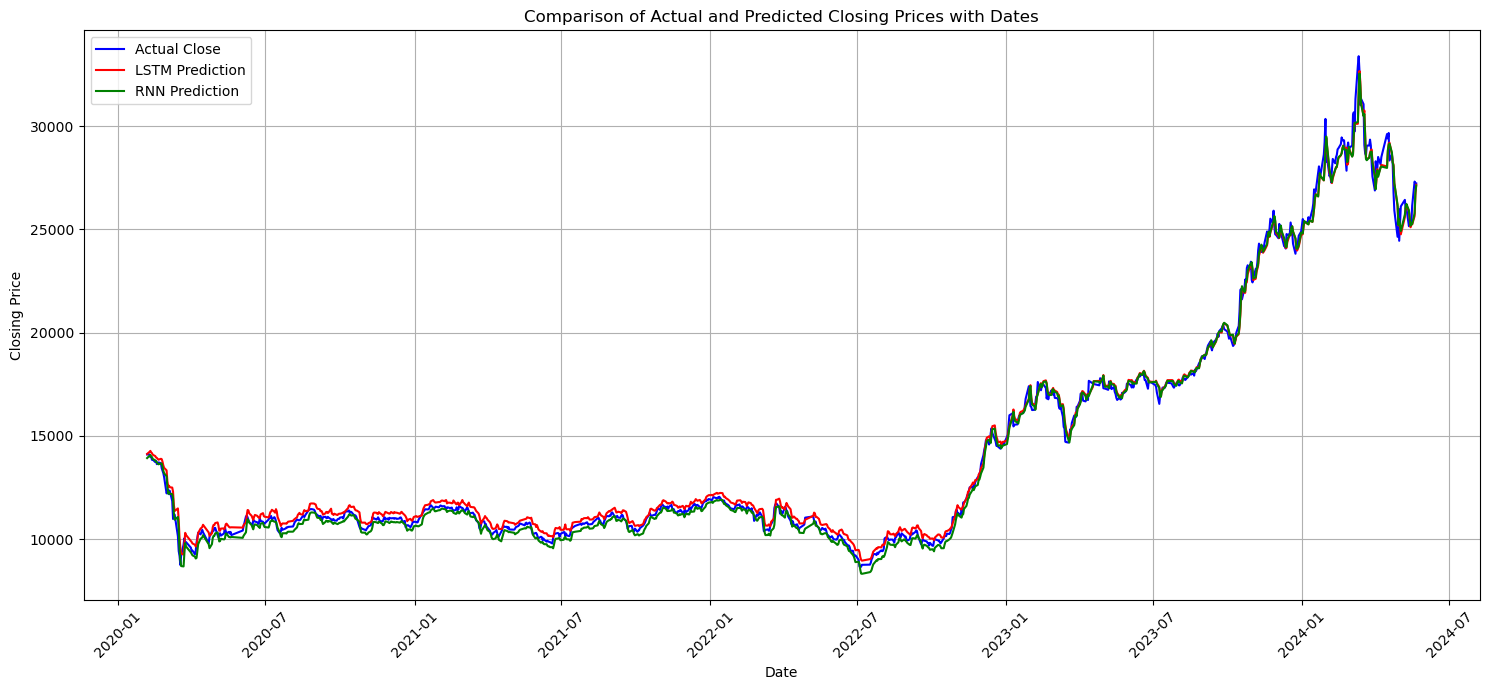

                 Date  Actual Close  LSTM Predicted Close  RNN Predicted Close
Date                                                                          
2024-05-15 2024-05-15      25316.08          25285.703125         25300.697266
2024-05-16 2024-05-16      26142.84          25236.054688         25259.103516
2024-05-19 2024-05-19      27315.83          25641.826172         25773.035156
2024-05-20 2024-05-20      27228.85          26653.029297         26790.578125
2024-05-21 2024-05-21      27224.80          27157.625000         27116.982422


In [190]:
def inverse_scale(scaler_dict, data, column_name):
    # Retrieve the correct scaler
    scaler = scaler_dict[column_name]
    # Reshape data for inverse scaling (scaler expects 2D array)
    data_reshaped = data.reshape(-1, 1)
    # Inverse transform and flatten the output
    return scaler.inverse_transform(data_reshaped).ravel()


# After making predictions
actual_prices_inversed = inverse_scale(scalers, test_y, 'Close')
lstm_predictions_inversed = inverse_scale(scalers, lstm_prediction, 'Close')
rnn_predictions_inversed = inverse_scale(scalers, rnn_prediction, 'Close')

test_dates = testDf.index

# Create a comprehensive DataFrame for comparison
full_comparison_df = pd.DataFrame({
    'Date': test_dates,
    'Actual Close': actual_prices_inversed,
    'LSTM Predicted Close': lstm_predictions_inversed,
    'RNN Predicted Close': rnn_predictions_inversed
}, index=test_dates)  # Ens


# Plotting the results with dates
plt.figure(figsize=(15, 7))
plt.plot(full_comparison_df['Date'], full_comparison_df['Actual Close'], label='Actual Close', color='blue')
plt.plot(full_comparison_df['Date'], full_comparison_df['LSTM Predicted Close'], label='LSTM Prediction', color='red')
plt.plot(full_comparison_df['Date'], full_comparison_df['RNN Predicted Close'], label='RNN Prediction',  color='green')
plt.title('Comparison of Actual and Predicted Closing Prices with Dates')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Display the DataFrame
print(full_comparison_df.tail())


In [191]:
# Future Prediction Function
def predict_future_days(model, initial_input, n_days, scaler_dict, feature_name):
    future_predictions = []
    current_input = initial_input.copy()
    for _ in range(n_days):
        # Predict the next step
        next_day_pred = model.predict(current_input)
        # Inverse scale the prediction
        predicted_value = inverse_scale(scaler_dict, next_day_pred, feature_name)
        future_predictions.append(predicted_value)
        # Prepare the next input
        next_input = np.roll(current_input, -1, axis=1)
        next_input[0, -1, :] = next_day_pred  # Set the prediction as the input for the next step
        current_input = next_input
    return np.array(future_predictions).flatten()

# Predict 5 future days
n_future_days = 2
last_input = test_X[-1:].reshape(1, 1, test_X.shape[2])  # Get the last test input
future_predictions_lstm = predict_future_days(lstm, last_input, n_future_days, scalers, 'Close')
future_predictions_rnn = predict_future_days(rnn, last_input, n_future_days, scalers, 'Close')
# Generate future dates
last_date = df['Date'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_future_days, freq='D')


# Create a DataFrame for the predicted values with future dates
future_df_lstm = pd.DataFrame({
    'Date': future_dates,
    'LSTM Predicted Close': future_predictions_lstm
})

future_df_rnn = pd.DataFrame({
    'Date': future_dates,
    'RNN Predicted Close': future_predictions_rnn
})

print(future_df_lstm.head())
print("RNN")
print(future_df_rnn.head())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
        Date  LSTM Predicted Close
0 2024-05-22          27157.623047
1 2024-05-23          26994.205078
RNN
        Date  RNN Predicted Close
0 2024-05-22         27116.986328
1 2024-05-23         27221.800781


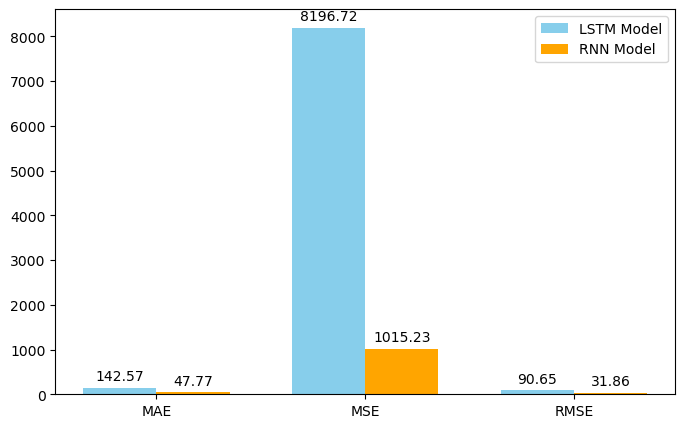

In [143]:

def plot_performance_metrics():
    # Define the performance metrics and their corresponding values for each model
    metrics = ['MAE', 'MSE', 'RMSE']
    lstm_values = [0.007014, 0.000122, 0.011031]
    rnn_values = [0.020934, 0.000985, 0.031388]

    # Invert the values to make the plot more intuitive (higher is better)
    lstm_inverted = [1 / value for value in lstm_values]
    rnn_inverted = [1 / value for value in rnn_values]

    # Set up the bar plot
    fig, ax = plt.subplots(figsize=(8, 5))  # Define the figure and its size
    x_indices = range(len(metrics))  # Determine the x positions for the groups of bars
    bar_width = 0.35  # Define the width of each bar

    # Plot bars for LSTM model
    lstm_bars = ax.bar(x_indices, lstm_inverted, bar_width, label='LSTM Model', color='skyblue')
    # Plot bars for RNN model
    rnn_bars = ax.bar([x + bar_width for x in x_indices], rnn_inverted, bar_width, label='RNN Model', color='orange')

    # Add details to the plot
    # ax.set_ylabel('Inverted Scores (Higher is Better)')  # Label for the y-axis
    # ax.set_title('Intuitive Comparison of LSTM and RNN models on stock prediction metrics')  # Title of the plot
    ax.set_xticks([x + bar_width / 2 for x in x_indices])  # Set x-axis ticks to be in the middle of the groups of bars
    ax.set_xticklabels(metrics)  # Label x-axis ticks with metric names
    ax.legend()  # Show legend to identify the bars

    # Add annotations to each bar for clarity
    for bars in (lstm_bars, rnn_bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',  # Format the height with two decimal places
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # Position the text 3 points above the bar
                        textcoords="offset points",
                        ha='center', va='bottom')  # Center-align the text horizontally

    plt.show()

plot_performance_metrics()


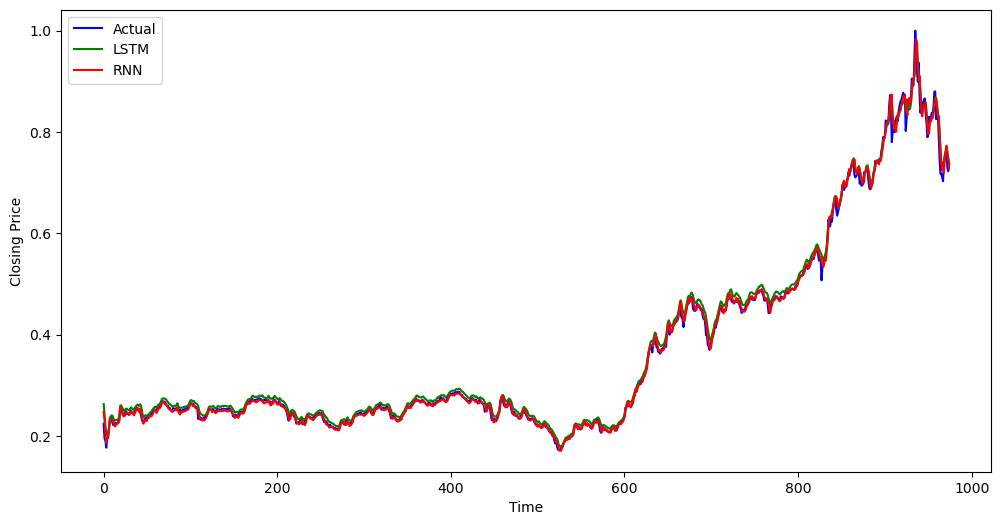

In [144]:
# Time Series Plot
plt.figure(figsize=(12, 6))
plt.plot(test_y, label='Actual', color='blue')
plt.plot(lstm_prediction, label='LSTM', color='green')
plt.plot(rnn_prediction, label='RNN', color='red')
# plt.title('Actual vs. Predicted Closing Prices')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()
plt.show()


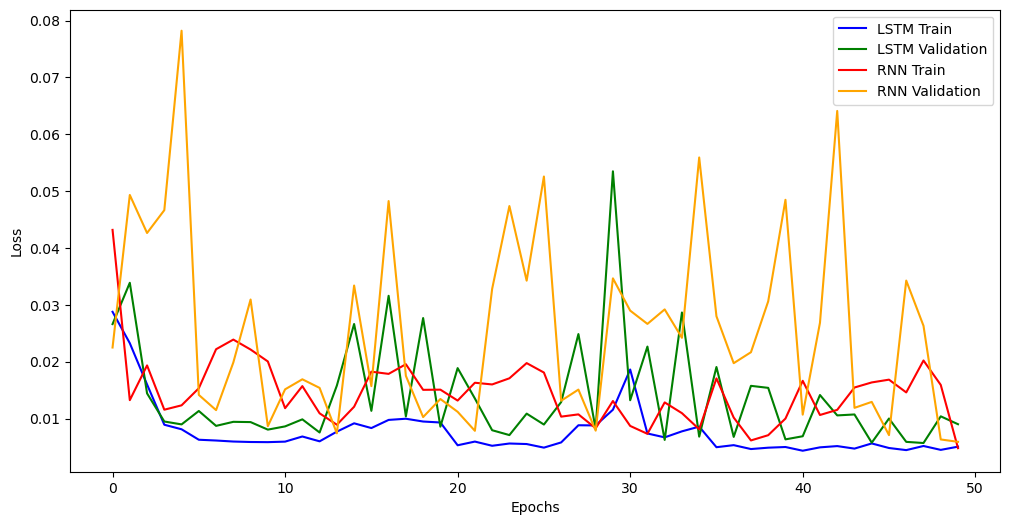

In [145]:
# Model Loss Plot
plt.figure(figsize=(12, 6))
plt.plot(lstmhistory.history['loss'], label='LSTM Train', color='blue')
plt.plot(lstmhistory.history['val_loss'], label='LSTM Validation', color='green')
plt.plot(rnnhistory.history['loss'], label='RNN Train', color='red')
plt.plot(rnnhistory.history['val_loss'], label='RNN Validation', color='orange')
# plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

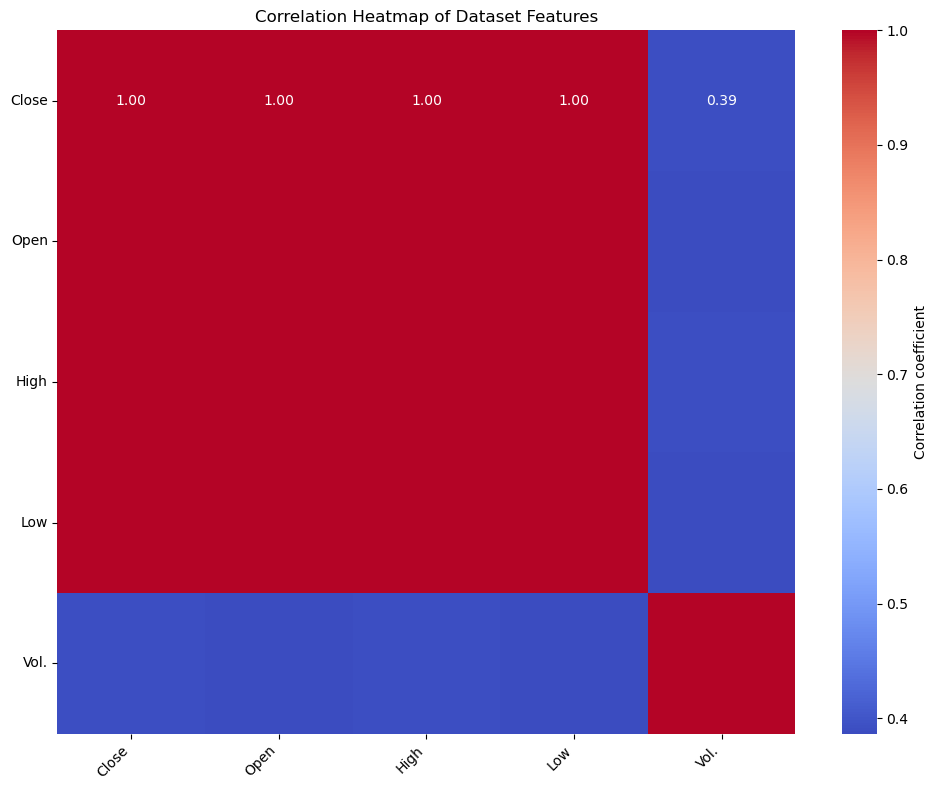

In [146]:
def plot_correlation_heatmap(data):
    # Calculate the correlation matrix
    corr = data.corr()

    # Generate a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm',
                xticklabels=corr.columns, yticklabels=corr.columns,
                cbar_kws={'label': 'Correlation coefficient'})
    plt.title('Correlation Heatmap of Dataset Features')
    plt.xticks(rotation=45, ha='right')  # Improve label display
    plt.yticks(rotation=0)
    plt.tight_layout()  # Adjusts plot to ensure everything fits without overlap
    plt.show()
plot_correlation_heatmap(scaleddata)